In [7]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline


In [8]:
PARTNER_ID = 179

In [9]:
#Extra functions helpers to make plots
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

In [36]:
#utils for trainning

random_forest = RandomForestClassifier(n_estimators=100)

def do_undersampling(df_to_undersampling, target, desiredRate=0.10):
    # Get the indices per target value
    idx_0 = df_to_undersampling[df_to_undersampling[target] == False].index
    idx_1 = df_to_undersampling[df_to_undersampling[target] == True].index

    # Get original number of records per target value
    nb_0 = len(df_to_undersampling.loc[idx_0])
    nb_1 = len(df_to_undersampling.loc[idx_1])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1-desiredRate)*nb_1)/(nb_0*desiredRate)
    undersampled_nb_0 = int(undersampling_rate*nb_0)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)

    # Return undersample data frame
    return df_to_undersampling.loc[idx_list].reset_index(drop=True)

def do_train(df_to_train, n_splits = 5):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        print( "\nFold ", i+1)
        random_forest.fit(X_train, y_train)
        acc_random_forest = round(random_forest.score(X_valid, y_valid) * 100, 2)
        print("Accuracy = {}".format(acc_random_forest))
        Y_test_pred = random_forest.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        print("AUC = {}".format(metrics.auc(fpr, tpr)))
        
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact        


## Read Data

In [11]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']

connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [45]:
# build the pandas dataframe with the bid information
original_df = pd.read_sql_query("select * from ml_prep.last_bid_usd_with_offer_179", con)
original_df.head()

OperationalError: (psycopg2.OperationalError) SSL SYSCALL error: EOF detected
 [SQL: 'select * from ml_prep.last_bid_usd_with_offer_179'] (Background on this error at: http://sqlalche.me/e/e3q8)

In [14]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229202 entries, 0 to 1229201
Data columns (total 33 columns):
event_id                              1229202 non-null object
event_time                            1229202 non-null object
request_id                            1229202 non-null object
partner_id                            1229202 non-null int64
origin                                1229202 non-null object
destination                           1229202 non-null object
flight_number                         1229202 non-null int64
departure_date                        1229202 non-null object
departure_time                        1229202 non-null object
currency                              1229202 non-null object
pnr                                   1229202 non-null object
language                              1229202 non-null object
pax                                   1229202 non-null int64
eligibility                           1229202 non-null bool
point_of_sale           

In [15]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [16]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
1229197  2017-10-02T19:37:08Z         179    YYZ         SFO            737   
1229198  2017-12-12T19:26:19Z         179    YYZ         YEG            177   
1229199  2017-10-02T02:52:21Z         179    YYZ         EWR           7686   
1229200  2018-01-20T03:28:09Z         179    SAN         YYZ           1886   
1229201  2017-10-30T20:37:27Z         179    YUL         PVG             17   

        departure_date departure_time currency language  pax   ...    \
1229197     2017-10-12          08:00      CAD       en    2   ...     
1229198     2017-12-22          23:10      USD       en    1   ...     
1229199     2017-10-11          16:00      CAD       en    1   ...     
1229200     2018-02-01          11:40      CAD       en    1   ...     
1229201     2017-11-30          13:10      CAD       en    1   ...     

         upgrade_type duration distance equipment slider_max_usd  \
1229197      BUSINESS      320     2256       789          639.0   
1229198      BUSINESS      252     1673       321          715.0   
1229199      BUSINESS       90      348       E75          479.0   
1229200      BUSINESS      270     2155       321          784.0   
1229201      BUSINESS      855     7062       788         1715.0   

        slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
1229197          216.0            296.0           NaN          NaN   False  
1229198          287.0            369.0           NaN          NaN   False  
1229199          144.0            220.0           NaN          NaN   False  
1229200          400.0            524.0           NaN          NaN   False  
1229201          780.0            936.0           NaN          NaN   False  

[5 rows x 26 columns]

In [17]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number           pax      duration      distance  \
count   1229202.0   1.229202e+06  1.229202e+06  1.229202e+06  1.229202e+06   
mean        179.0   1.148571e+03  1.513366e+00  3.760542e+02  2.945064e+03   
std           0.0   1.946316e+03  8.339487e-01  2.409841e+02  2.156280e+03   
min         179.0   1.000000e+00  1.000000e+00  2.400000e+01  3.300000e+01   
25%         179.0   1.180000e+02  1.000000e+00  1.870000e+02  1.232000e+03   
50%         179.0   6.190000e+02  1.000000e+00  2.970000e+02  2.173000e+03   
75%         179.0   9.750000e+02  2.000000e+00  5.350000e+02  4.364000e+03   
max         179.0   8.987000e+03  9.000000e+00  1.237000e+03  9.676000e+03   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count    1.229202e+06    1.229202e+06      1.229202e+06  48038.000000   
mean     8.202704e+02    3.833092e+02      5.044752e+02    435.567057   
std      4.541090e+02    2.733237e+02      3.231382e+02    297.348171   
min      1.920000e+02    4.900000e+01      7.700000e+01     62.047200   
25%      4.830000e+02    1.770000e+02      2.600000e+02    221.360400   
50%      6.750000e+02    2.840000e+02      4.090000e+02    321.884150   
75%      1.002000e+03    5.480000e+02      6.860000e+02    600.920600   
max      8.840000e+03    1.859000e+03      2.214000e+03   2506.257500   

        customer_id  
count  4.803800e+04  
mean   3.819249e+06  
std    2.640682e+05  
min    2.888761e+06  
25%    3.699937e+06  
50%    3.851524e+06  
75%    4.019448e+06  
max    4.186260e+06

In [18]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time   origin destination departure_date  \
count                1229202  1229202     1229202        1229202   
unique                472735      146         142            515   
top     2018-02-16T19:05:30Z      YYZ         YYZ     2017-12-22   
freq                      23   348519      371885           8691   

       departure_time currency language point_of_sale    channel_source  \
count         1229202  1229202  1229202       1229202           1229202   
unique            249       12        8            68                12   
top             08:00      CAD       en            CA  PRE_TRAVEL_EMAIL   
freq            26330  1011220  1178136        987746            652331   

       carrier_code fare_class from_cabin upgrade_type equipment  
count       1229202    1229202    1229202      1229202   1229202  
unique            1         19          2            2        19  
top              AC          K    ECONOMY     BUSINESS       77W  
freq        1229202     424409    1177305       953068    226777

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229202 entries, 0 to 1229201
Data columns (total 26 columns):
event_time          1229202 non-null object
partner_id          1229202 non-null int64
origin              1229202 non-null object
destination         1229202 non-null object
flight_number       1229202 non-null int64
departure_date      1229202 non-null object
departure_time      1229202 non-null object
currency            1229202 non-null object
language            1229202 non-null object
pax                 1229202 non-null int64
eligibility         1229202 non-null bool
point_of_sale       1229202 non-null object
channel_source      1229202 non-null object
carrier_code        1229202 non-null object
fare_class          1229202 non-null object
from_cabin          1229202 non-null object
upgrade_type        1229202 non-null object
duration            1229202 non-null int64
distance            1229202 non-null int64
equipment           1229202 non-null object
slider_max_usd

In [20]:
dfPartner = df[df["partner_id"] == PARTNER_ID].copy()
dfPartner.drop(["partner_id", "eligibility"], axis = 1, inplace = True)
dfPartner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1229202 entries, 0 to 1229201
Data columns (total 24 columns):
event_time          1229202 non-null object
origin              1229202 non-null object
destination         1229202 non-null object
flight_number       1229202 non-null int64
departure_date      1229202 non-null object
departure_time      1229202 non-null object
currency            1229202 non-null object
language            1229202 non-null object
pax                 1229202 non-null int64
point_of_sale       1229202 non-null object
channel_source      1229202 non-null object
carrier_code        1229202 non-null object
fare_class          1229202 non-null object
from_cabin          1229202 non-null object
upgrade_type        1229202 non-null object
duration            1229202 non-null int64
distance            1229202 non-null int64
equipment           1229202 non-null object
slider_max_usd      1229202 non-null float64
slider_min_usd      1229202 non-null float64
slider_st

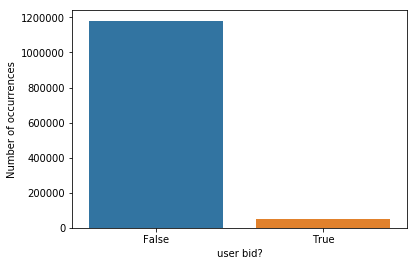

Has_bid percentage: 4.07%


In [21]:
#What is the distribution of has bid
sns.countplot(dfPartner.has_bid);
plt.xlabel('user bid?');
plt.ylabel('Number of occurrences');
plt.show()
has_bid_counts = dfPartner["has_bid"].value_counts().tolist()
print("Has_bid percentage: {0:.2f}%".format(has_bid_counts[1] / has_bid_counts[0] * 100))


## Visualization analysis

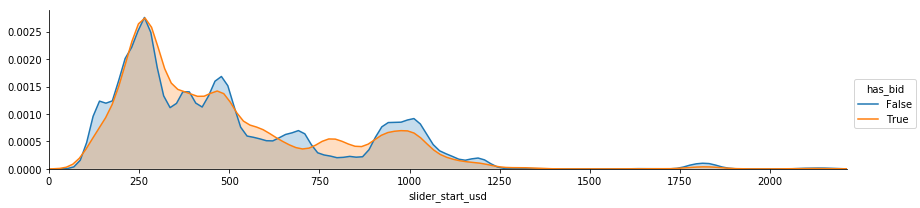

In [22]:
plot_distribution( dfPartner , var = 'slider_start_usd' , target = 'has_bid' )

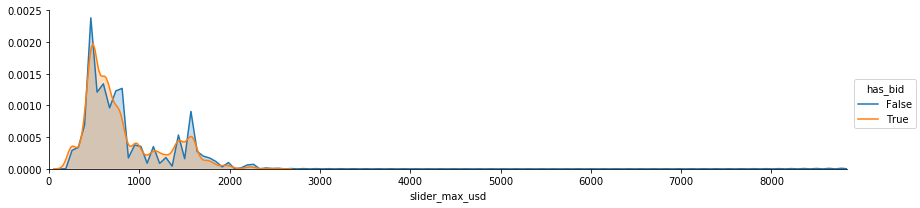

In [23]:
plot_distribution( dfPartner , var = 'slider_max_usd' , target = 'has_bid' )

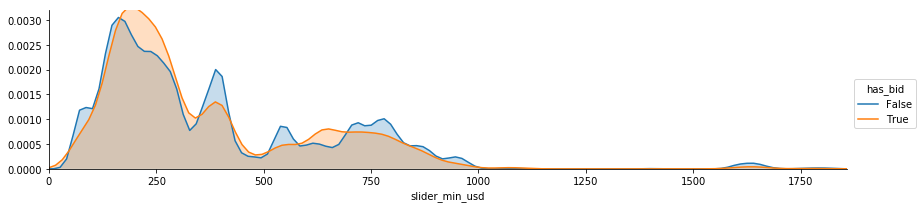

In [24]:
plot_distribution( dfPartner , var = 'slider_min_usd' , target = 'has_bid' )

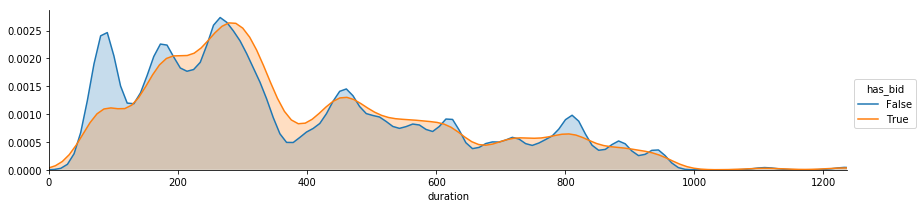

In [25]:
plot_distribution( dfPartner , var = 'duration' , target = 'has_bid' )

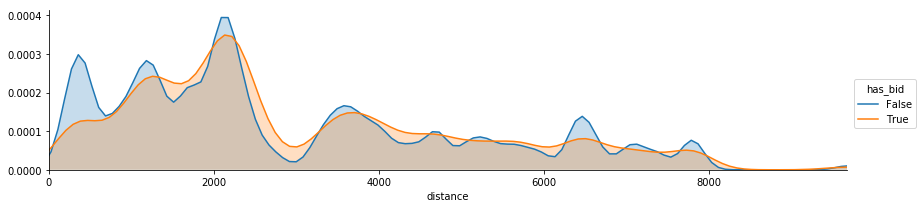

In [26]:
plot_distribution( dfPartner , var = 'distance' , target = 'has_bid' )

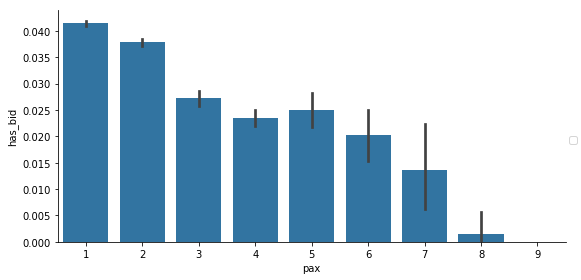

In [27]:
plot_categories( dfPartner , cat = 'pax' , target = 'has_bid' )

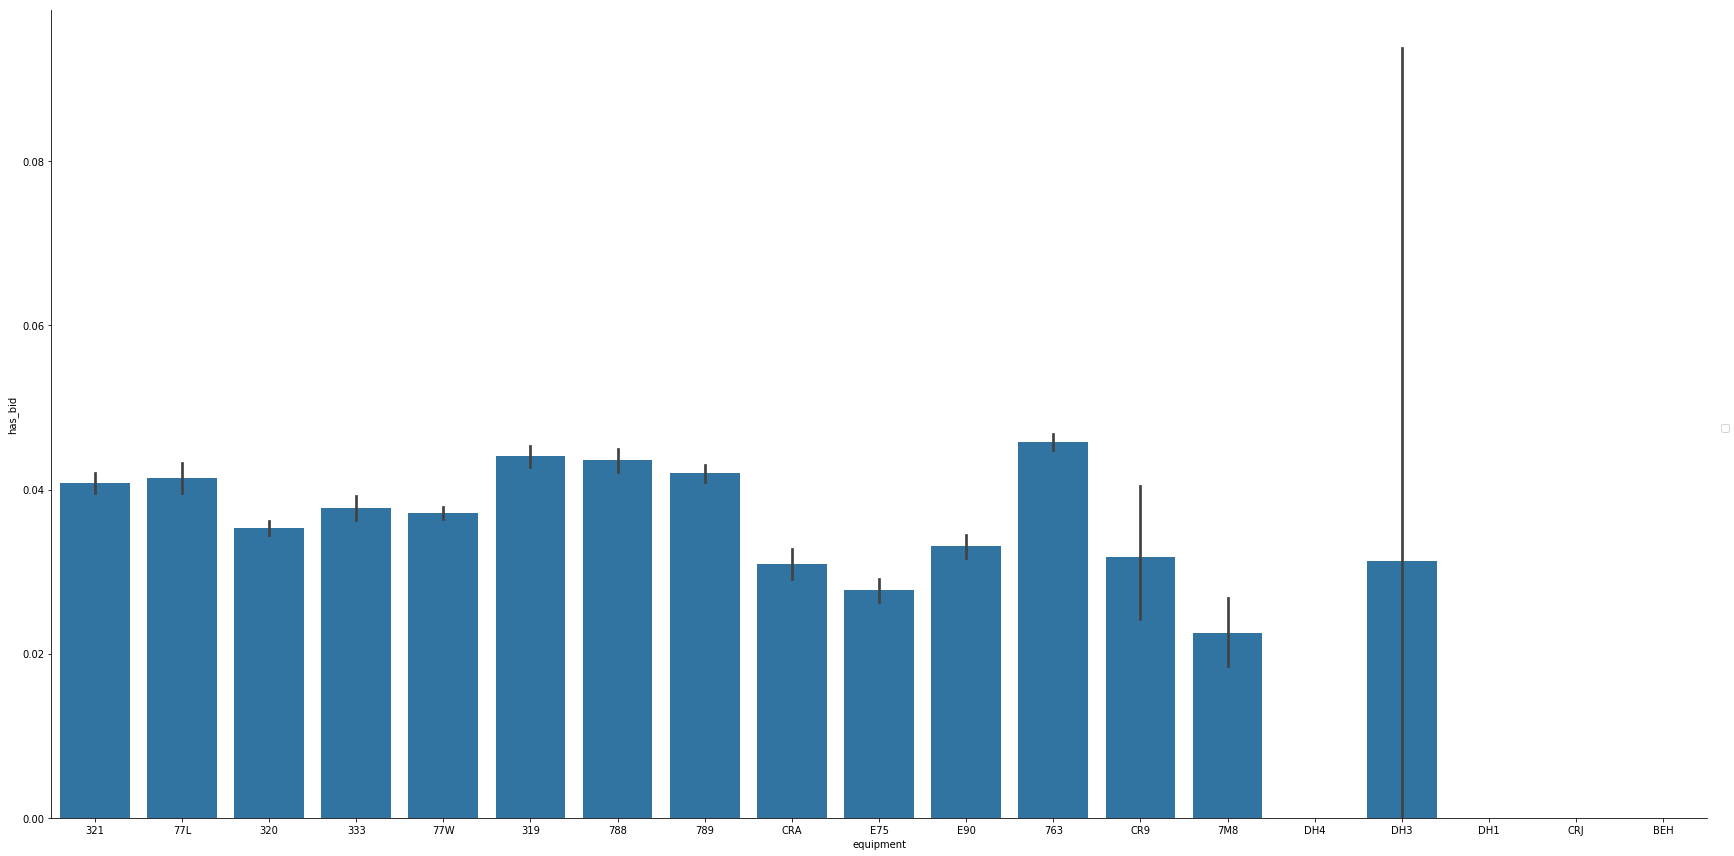

In [28]:
plot_categories( dfPartner , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

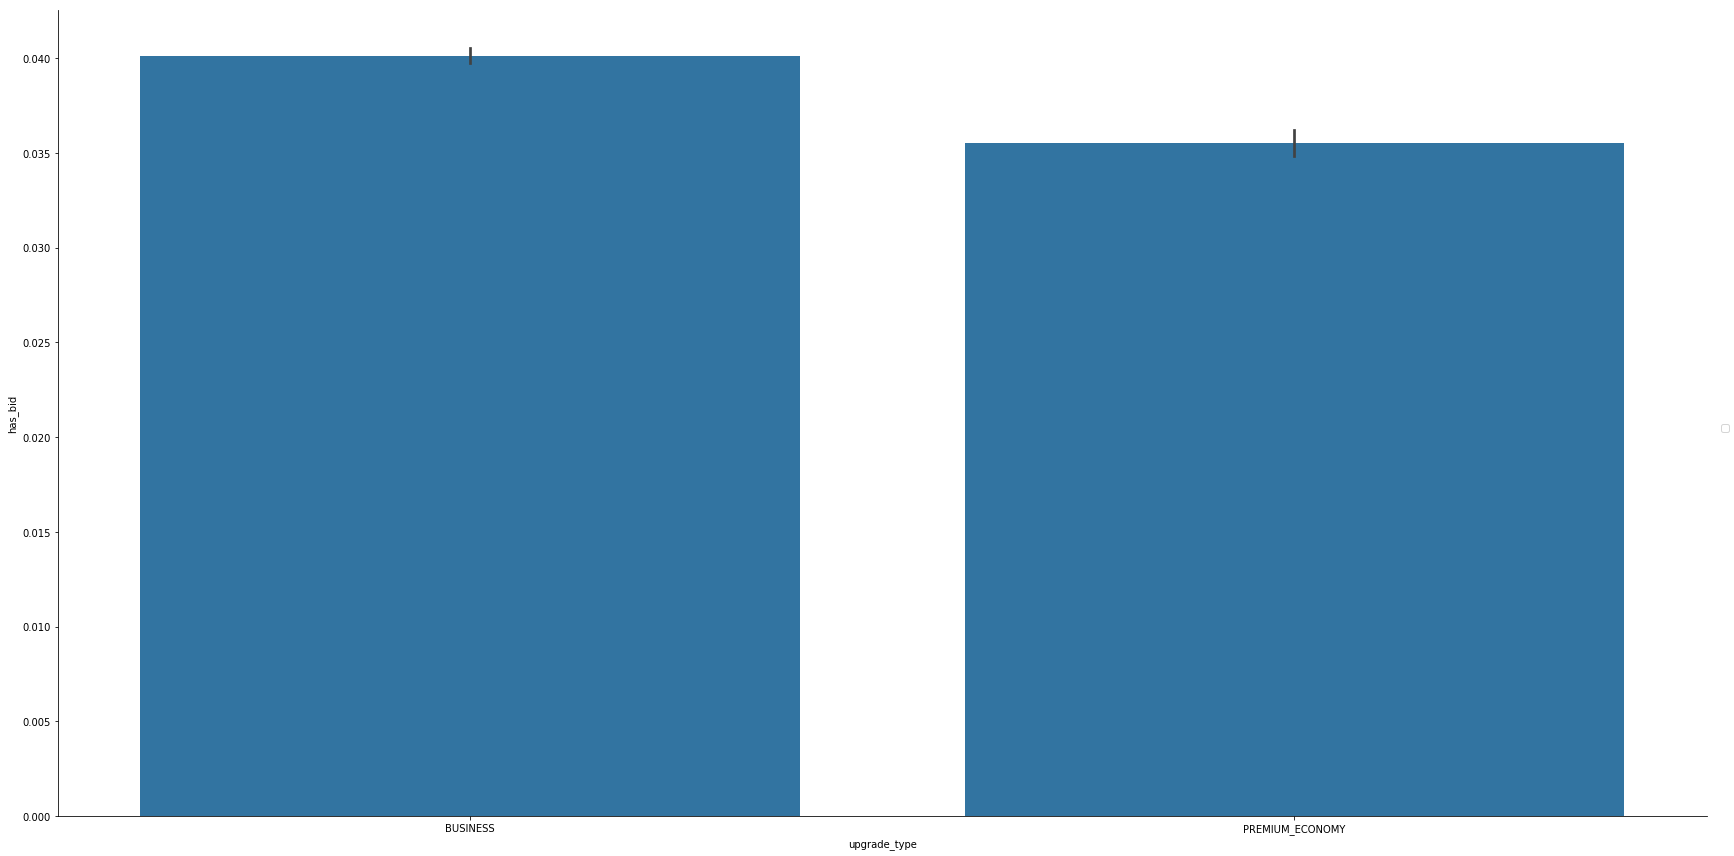

In [29]:
plot_categories( dfPartner , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

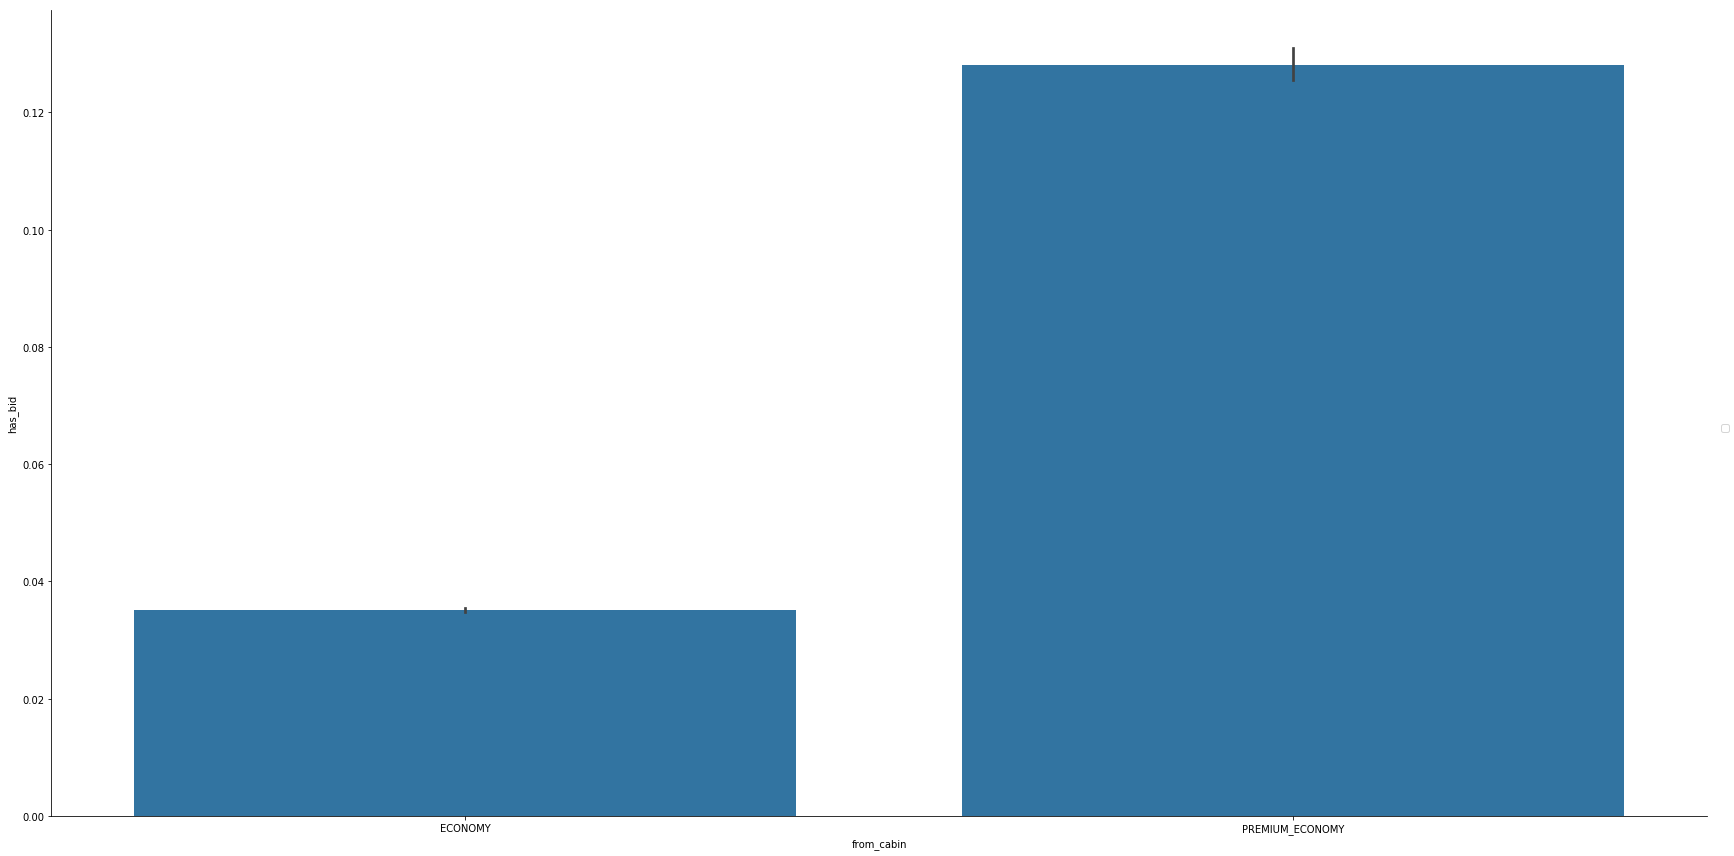

In [30]:
plot_categories( dfPartner , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

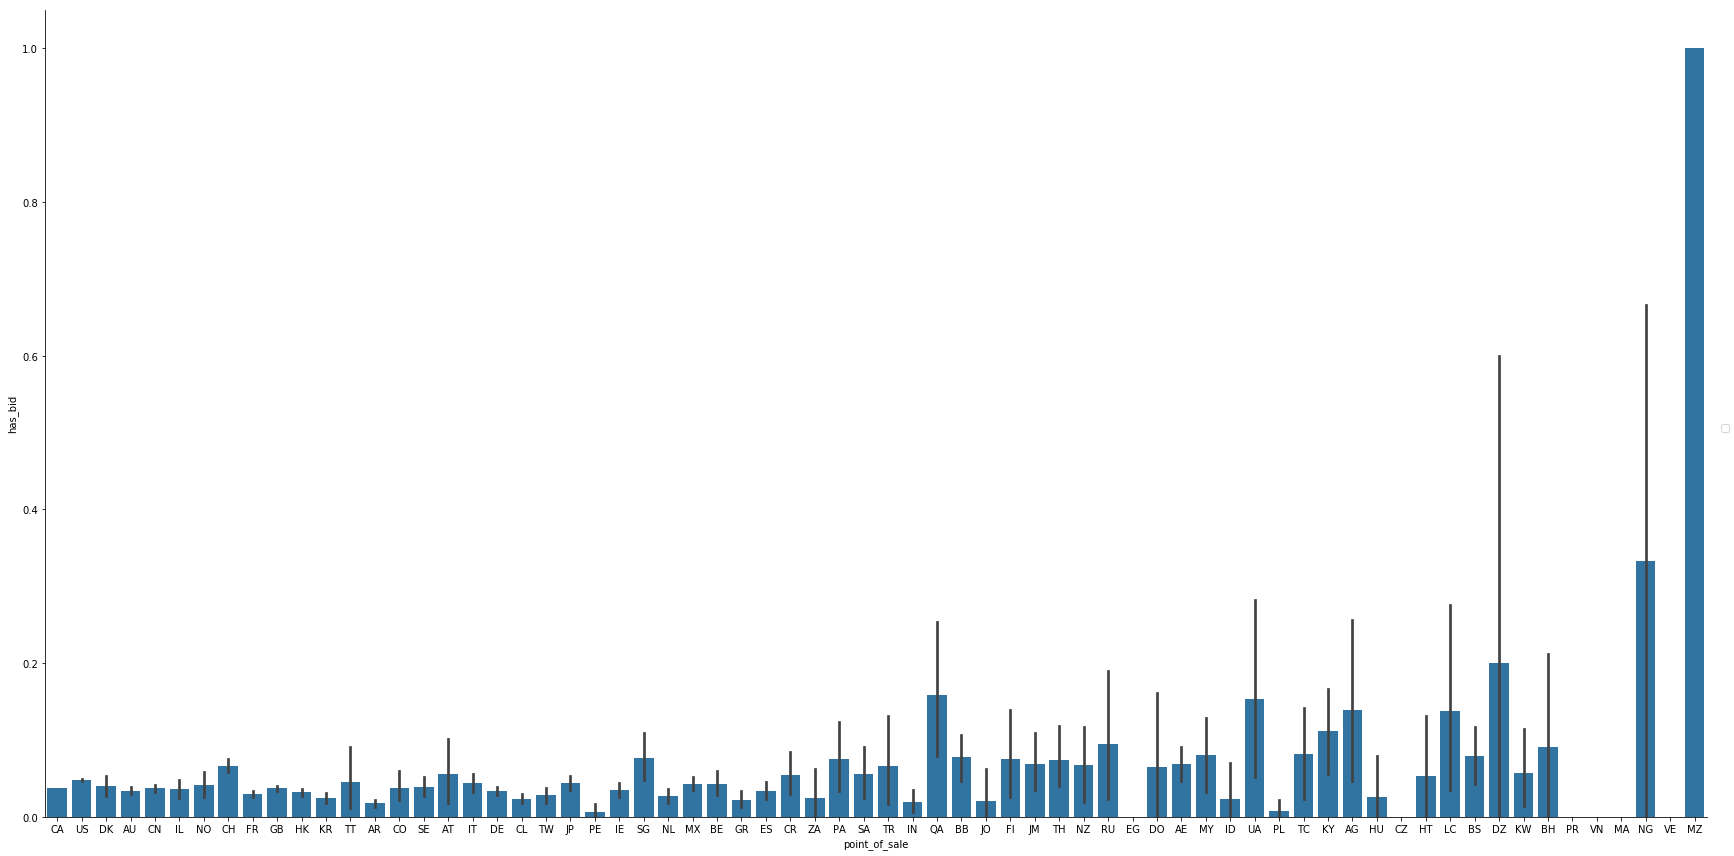

In [31]:
plot_categories( dfPartner , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

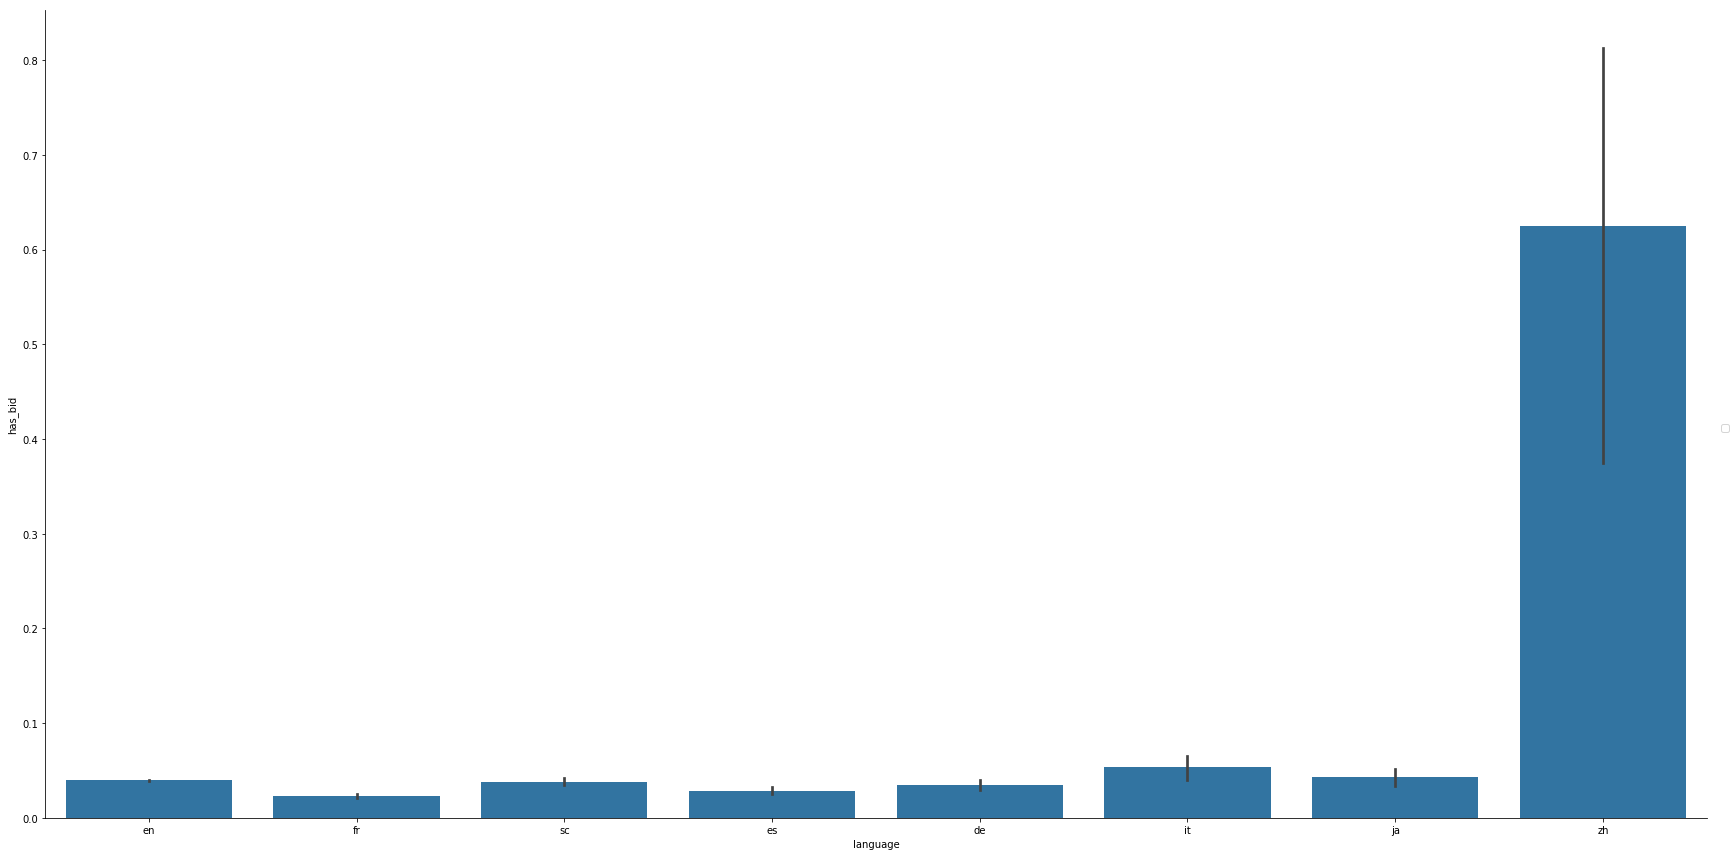

In [32]:
plot_categories( dfPartner , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

## Wrangle Data

In [33]:
train_df = dfPartner.copy()

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1229202 entries, 0 to 1229201
Data columns (total 24 columns):
event_time          1229202 non-null object
origin              1229202 non-null object
destination         1229202 non-null object
flight_number       1229202 non-null int64
departure_date      1229202 non-null object
departure_time      1229202 non-null object
currency            1229202 non-null object
language            1229202 non-null object
pax                 1229202 non-null int64
point_of_sale       1229202 non-null object
channel_source      1229202 non-null object
carrier_code        1229202 non-null object
fare_class          1229202 non-null object
from_cabin          1229202 non-null object
upgrade_type        1229202 non-null object
duration            1229202 non-null int64
distance            1229202 non-null int64
equipment           1229202 non-null object
slider_max_usd      1229202 non-null float64
slider_min_usd      1229202 non-null float64
slider_st

In [41]:
#do undersampling to 20%, add new features: days before departure and destination_origin

train_df2 = train_df.copy()
#train_df2_020 = do_undersampling(train_df2, 'has_bid', 0.20)
train_df2_020 = train_df2
train_df2_020["departure_time"] = train_df2_020.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)
train_df2_020["event_time"] = train_df2_020["event_time"].astype('datetime64[ns]')
train_df2_020["event_time"] = train_df2_020["event_time"].apply(lambda x: x.date() )
train_df2_020["departure_date"] = train_df2_020["departure_date"].astype('datetime64[ns]')
train_df2_020["departure_date"] = train_df2_020["departure_date"].apply(lambda x: x.date() )
train_df2_020["days_before_departure"] = train_df2_020["departure_date"] - train_df2_020["event_time"]
train_df2_020["days_before_departure"] = train_df2_020["days_before_departure"].apply(lambda x: x.days)
train_df2_020["destination_origin"] = train_df2_020["destination"]  + "-" + train_df2_020["origin"]

In [42]:
train_df2_020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1229202 entries, 0 to 1229201
Data columns (total 26 columns):
event_time               1229202 non-null object
origin                   1229202 non-null object
destination              1229202 non-null object
flight_number            1229202 non-null int64
departure_date           1229202 non-null object
departure_time           1229202 non-null object
currency                 1229202 non-null object
language                 1229202 non-null object
pax                      1229202 non-null int64
point_of_sale            1229202 non-null object
channel_source           1229202 non-null object
carrier_code             1229202 non-null object
fare_class               1229202 non-null object
from_cabin               1229202 non-null object
upgrade_type             1229202 non-null object
duration                 1229202 non-null int64
distance                 1229202 non-null int64
equipment                1229202 non-null object
slider_ma

In [43]:
#save dataframes as csvs (for binary model and regression)
import datetime
now = datetime.datetime.utcnow()
BINARY_CSV = "last_bid_data_exploration_{}_binary_{}.csv".format(PARTNER_ID,now)
REGRESSION_CSV = "last_bid_data_exploration_{}_regression_{}.csv".format(PARTNER_ID,now)
df_to_export = train_df2_020.drop(["departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale", "offer_amount", "customer_id"], axis=1)
df_to_export.to_csv(BINARY_CSV, header=True, index=False)
df_to_export = train_df2_020.drop(["departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale", "has_bid", "customer_id"], axis=1)
df_to_export.to_csv(REGRESSION_CSV, header=True, index=False)

In [44]:
import boto3

#save artifacts
boto3.Session().resource('s3').Bucket("pg-ml-repository").Object('sagemaker/data-exploration-artifacts/{}'.format(BINARY_CSV)).upload_file(BINARY_CSV)
boto3.Session().resource('s3').Bucket("pg-ml-repository").Object('sagemaker/data-exploration-artifacts/{}'.format(REGRESSION_CSV)).upload_file(REGRESSION_CSV)


In [114]:
#Add file to the modelDataSources folder to be imported by service-pricing 
#boto3.Session().resource('s3').Bucket("pg-ml-repository").Object('modelDataSources/partner{}.csv'.format(PARTNER_ID)).upload_file(BINARY_CSV)
#access denied from sagemaker

S3UploadFailedError: Failed to upload last_bid_data_exploration_35_binary_2018-02-14 11:30:30.942568.csv to pg-ml-repository/modelDataSources/partner35.csv: An error occurred (AccessDenied) when calling the CreateMultipartUpload operation: Access Denied